# Summary
This tutorial demonstrates how to train a deep neural network using the Pylearn2 framework on the Supersymmetry data set. 

## Requirements:
1) numpy, matplotlib, pickle

2) theano, pylearn2

3) SUSY data set from UCI ML Repository


In [7]:
import sys
import os
import pickle
import numpy
import theano
print theano.config.device

import pylearn2
import pylearn2.datasets
import pylearn2.training_algorithms
import pylearn2.training_algorithms.sgd
import pylearn2.costs
import pylearn2.models.mlp as mlp
import pylearn2.train
import pylearn2.termination_criteria
import matplotlib
%matplotlib inline

# Data set
A Pylearn2 dataset object can be created from a numpy array. The input data $X$ is given by a $N$-by-$D$ matrix, where $N$ is the number of examples and $D$ is the number of input features. The targets are given by a $N$-by-$1$ matrix $y$, with values in ${0,1}$. Note that all values should be represented as float32.

In [14]:
def load_dataset(which_set, which_features):
    # Load full dataset. 
    # E.G. dataset = load_dataset(which_set='train', which_features='all')
    inputfile = './SUSY_100k.csv.gz'
    X = numpy.loadtxt(inputfile, dtype='float32', delimiter=',') # Pylearn2 expects float32!
    y = X[:,0].reshape((-1,1))
    X = X[:,1:]

    # Specify which features to use.
    if which_features == 'all':
        pass
    elif which_features == 'high':    
        X = X[:, 8:18] # Only the 10 high-level features.
    elif which_features == 'low':
        X = X[:, 0:8]     # Only the 8 low-level features.
    else:
        raise ValueError('Bad input for argument features.')
    
    # Split data into train, valid, test.
    ntrain, nvalid, ntest = 50000, 25000, 25000
    if which_set == 'train':
        X = X[:ntrain, :]
        y = y[:ntrain, :]
    elif which_set == 'valid':
        X = X[ntrain:ntrain+nvalid, :]
        y = y[ntrain:ntrain+nvalid, :]
    elif which_set == 'test':
        X = X[ntrain+nvalid:ntrain+nvalid+ntest, :]
        y = y[ntrain+nvalid:ntrain+nvalid+ntest, :]
    
    return pylearn2.datasets.dense_design_matrix.DenseDesignMatrix(X=X, y=y)

dataset_train = load_dataset(which_set='train', which_features='all')
dataset_valid = load_dataset(which_set='valid', which_features='all')

# Model
Deep neural network models are created in Pylearn2 using the Multi-Layer Perceptron (MLP) class. The network architecture is specified by a list of Layer objects, each of which consists of a linear tranformation followed by a non-linear activation function.

In [32]:
layers = []
nvis = dataset_train.X.shape[1] # Number of input features.
nhid = 100 # Hidden neurons per layer.

# Layer 0
istdev = 1.0/numpy.sqrt(nvis)         # Initial weights selected from normal distribution.
layer = pylearn2.models.mlp.RectifiedLinear(layer_name = 'h0', dim=nhid, istdev=istdev)
layers.append(layer)

# Layer 1
istdev = 1.0/numpy.sqrt(nhid)
layer = pylearn2.models.mlp.RectifiedLinear(layer_name = 'h1', dim=nhid, istdev=istdev)
layers.append(layer)

# Output layer.
layer = mlp.Sigmoid(layer_name='y', dim=1, istdev=0.001)
layers.append(layer)

# MLP Model
model = pylearn2.models.mlp.MLP(layers, nvis=nvis, seed=36)

# Training Algorithm
Neural networks are typically trained using stochastic gradient descent (SGD). There are a number of tricks and parameter choices that go into this. 

In [41]:
# Objective function to be optimized.
cost = pylearn2.costs.mlp.Default()      # Defaults to cross-entropy loss for sigmoid output.
weight_decay = [0.00001 for _ in layers] # L2 weight penalty for each layer.
cost_wd = pylearn2.costs.mlp.WeightDecay(coeffs = weight_decay)
cost = pylearn2.costs.cost.SumOfCosts(costs=[cost, cost_wd])
    
# Algorithm
args = {}
args['batch_size']    = 100
args['learning_rate'] = 0.01
args['learning_rule'] = pylearn2.training_algorithms.learning_rule.Momentum(init_momentum = 0.5)
args['monitoring_dataset'] = {'train':dataset_train, 'valid':dataset_valid}
args['termination_criterion'] = pylearn2.termination_criteria.EpochCounter(max_epochs=10)
args['cost'] = cost
args['update_callbacks'] = pylearn2.training_algorithms.sgd.ExponentialDecay(
                                    decay_factor = 1.0000002053, # Decreases every batch. 
                                    min_lr=.000001
                                    )
algorithm = pylearn2.training_algorithms.sgd.SGD(**args)

# Extensions 
extensions = [pylearn2.training_algorithms.learning_rule.MomentumAdjustor(
                start=0,
                saturate = 5,
                final_momentum = 0.99)]

filename_model = './supersymmetry.pkl'
train = pylearn2.train.Train(dataset=dataset_train,
                             model=model,
                             algorithm=algorithm,
                             extensions=extensions,
                             save_path=filename_model,
                             save_freq=5)

/home/pjsadows/venv/src/pylearn2/pylearn2/train.py:85: UserWarning: dataset has no yaml src, model won't know what data it was trained on
  "data it was trained on")


# Train model

In [49]:
# Run training loop.
train.main_loop()

Parameter and initial learning rate summary:


/home/pjsadows/venv/src/pylearn2/pylearn2/costs/mlp/__init__.py:105: UserWarning: Coefficients should be given as a dictionary with layer names as key. The support of coefficients as list would be deprecated from 03/06/2015
  warnings.warn("Coefficients should be given as a dictionary "


	h0_W: 0.00999999977648
	h0_b: 0.00999999977648
	h1_W: 0.00999999977648
	h1_b: 0.00999999977648
	y_W: 0.00999999977648
	y_b: 0.00999999977648
Compiling sgd_update...
Compiling sgd_update done. Time elapsed: 0:01:33.319598
compiling begin_record_entry...
compiling begin_record_entry done. Time elapsed: 4.589898 seconds
Monitored channels: 
	learning_rate
	momentum
	total_seconds_last_epoch
	train_h0_col_norms_max
	train_h0_col_norms_mean
	train_h0_col_norms_min
	train_h0_max_x_max_u
	train_h0_max_x_mean_u
	train_h0_max_x_min_u
	train_h0_mean_x_max_u
	train_h0_mean_x_mean_u
	train_h0_mean_x_min_u
	train_h0_min_x_max_u
	train_h0_min_x_mean_u
	train_h0_min_x_min_u
	train_h0_range_x_max_u
	train_h0_range_x_mean_u
	train_h0_range_x_min_u
	train_h0_row_norms_max
	train_h0_row_norms_mean
	train_h0_row_norms_min
	train_h1_col_norms_max
	train_h1_col_norms_mean
	train_h1_col_norms_min
	train_h1_max_x_max_u
	train_h1_max_x_mean_u
	train_h1_max_x_min_u
	train_h1_mean_x_max_u
	train_h1_mean_x_mean_

/home/pjsadows/venv/src/pylearn2/pylearn2/monitor.py:572: UserWarning: Trained model saved without indicating yaml_src
  'indicating yaml_src')


Time this epoch: 0.722349 seconds
Monitoring step:
	Epochs seen: 6
	Batches seen: 3000
	Examples seen: 300000
	learning_rate: 0.00999385211617
	momentum: 0.99000287056
	total_seconds_last_epoch: 6.96970653534
	train_h0_col_norms_max: 2.54334187508
	train_h0_col_norms_mean: 1.10328745842
	train_h0_col_norms_min: 0.65895062685
	train_h0_max_x_max_u: 12.2447404861
	train_h0_max_x_mean_u: 1.8356808424
	train_h0_max_x_min_u: 0.00797031074762
	train_h0_mean_x_max_u: 1.60414159298
	train_h0_mean_x_mean_u: 0.198512002826
	train_h0_mean_x_min_u: 9.15090058697e-05
	train_h0_min_x_max_u: 0.00751443905756
	train_h0_min_x_mean_u: 7.51443876652e-05
	train_h0_min_x_min_u: 0.0
	train_h0_range_x_max_u: 12.2447404861
	train_h0_range_x_mean_u: 1.83560597897
	train_h0_range_x_min_u: 0.00797031074762
	train_h0_row_norms_max: 4.54266929626
	train_h0_row_norms_mean: 2.61258864403
	train_h0_row_norms_min: 1.72392868996
	train_h1_col_norms_max: 1.57648420334
	train_h1_col_norms_mean: 1.02917170525
	train_h1_co

In [11]:
# Load saved model.
model = pickle.load(open(filename_model, 'r'))

# Print objective function after training.
info = model.monitor.channels
print 'Train objective = %f' % info['train_y_01_loss'].val_record[-1]
print 'Valid objective = %f' % info['valid_y_01_loss'].val_record[-1]

Train objective = 0.198940
Valid objective = 0.205920


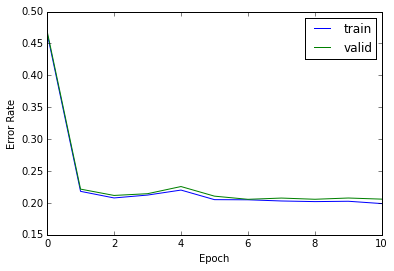

In [20]:
# Plot objective function.
matplotlib.pyplot.plot(info['train_y_01_loss'].val_record, label='train')
matplotlib.pyplot.plot(info['valid_y_01_loss'].val_record, label='valid')
matplotlib.pyplot.xlabel('Epoch')
matplotlib.pyplot.ylabel('Error Rate')
matplotlib.pyplot.legend()

# Predictions on New Data, ROC Curves

In [40]:
# Create symbolic theano function to make predictions.
X = model.get_input_space().make_theano_batch()  # Loads entire dataset into memory.
Y = model.fprop( X )
f = theano.function( [X], Y )
yhat = f(dataset_valid.X)

AUC = 0.868761


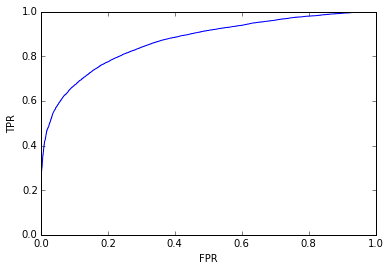

In [22]:
from sklearn import metrics
# Plot ROC curve and compute AUC.
fpr, tpr, thresholds = metrics.roc_curve(dataset_valid.y, yhat, pos_label=1)
matplotlib.pyplot.plot(fpr, tpr)
matplotlib.pyplot.xlabel('FPR')
matplotlib.pyplot.ylabel('TPR')
print 'AUC = %f' % metrics.auc(fpr, tpr)

 # Inspect Model Weights
 We can inspect the learned parameters of our model.

Weight matrix has shape: (18, 100)


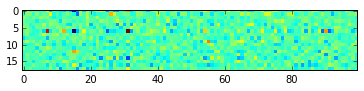

In [39]:
# Inspect weight parameters from first layer.
layer = model.layers[0]
W = layer.get_weights()
print 'Weight matrix has shape: ' + str(W.shape) # Shape is input dim by output dim
matplotlib.pyplot.imshow(W, interpolation='nearest')